<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [61]:
# librerias

import pandas as pd
import numpy as np
import pylab as plt
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem
from bayes import *
from scipy.stats import norm

In [123]:
def bayes(priori, verosimilitud):
    
    marginal = sum(np.multiply(priori, verosimilitud)) # cte normalizacion
    
    posteriori = np.divide(np.multiply(priori, verosimilitud), marginal)
    
    return posteriori

In [2]:
data = pd.read_csv('data/cookie_cats.csv')

In [4]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [124]:
cross_1 = pd.crosstab(data['version'], data['retention_1'])
cross_1

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


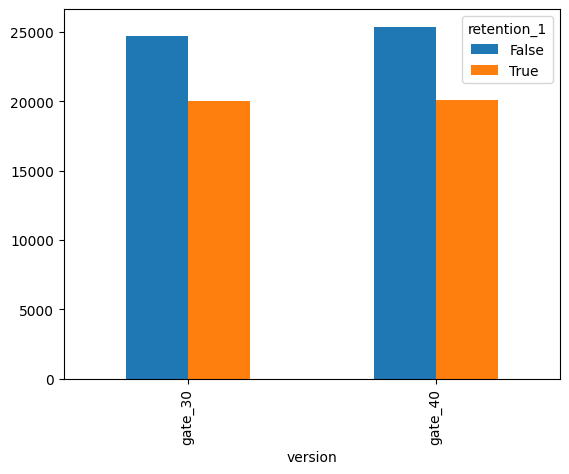

In [125]:
pd.crosstab(data['version'], data['retention_1']).plot(kind='bar'); 

In [40]:
cross[True][0] / (cross[True][0] + cross[False][0])
prop_30 = round(prop_30, 2)
prop_30

0.45

In [41]:
cross[True][1] / (cross[True][1] + cross[False][1])
prop_40 = round(prop_40, 2)
prop_40

0.44

In [36]:
efecto = sms.proportion_effectsize(0.45, 0.44)

efecto

0.02012246123322825

In [37]:
n_requerido = sms.NormalIndPower().solve_power(efecto,     
                                               power=0.8,
                                               alpha=0.05
                                              )

n_requerido

38768.09024379976

In [42]:
control = data[data.version == 'gate_30'].sample(n = 38768, random_state = 22)

tratamiento = data[data.version == 'gate_40'].sample(n = 38768, random_state = 22)

ab_test = pd.concat([control, tratamiento], axis=0)

ab_test.reset_index(drop = True, inplace = True)

ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,7540471,gate_30,45,True,False
1,3589138,gate_30,21,True,False
2,3177668,gate_30,14,True,False
3,2133884,gate_30,26,False,False
4,492763,gate_30,39,True,True


In [54]:
len(ab_test)

77536

In [49]:
g30_res = ab_test[ab_test['version'] == 'gate_30']['retention_1']

g40_res = ab_test[ab_test['version'] == 'gate_40']['retention_1']

In [55]:
sum(g30_res)

17374

In [56]:
sum(g40_res)

17206

In [59]:
impresiones = [38768, 38768]  # count  , impresiones
    
conversiones = [g30_res.sum(), g40_res.sum()]    # conversiones


z_score, p_value = proportions_ztest(conversiones, nobs = impresiones)

(g30_a, g40_a), (g30_res_b, g40_b) = proportion_confint(conversiones, 
                                                                nobs = impresiones,
                                                                alpha = 0.05)

In [60]:
print(f'z-score: {z_score:.2f}')

print(f'p-valor: {p_value:.3f}')

print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')

print(f'intervalo conf 95% para grupo tratamiento: [{trata_a:.3f}, {trata_b:.3f}]')

z-score: 1.21
p-valor: 0.225
intervalo conf 95% para grupo control: [0.443, 0.453]
intervalo conf 95% para grupo tratamiento: [0.439, 0.449]


In [ ]:
print(CR_ctrl, CR_test)
plt.figure(figsize = (12,6))
plot([beta_C, beta_T], ['Control', 'Test'], lsup = 0.17, linf = 0.21)

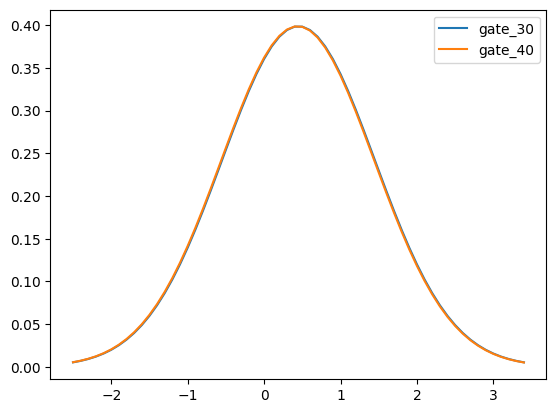

In [74]:
x = [i*.1 for i in range(-25, 35)]  

# norm.pdf(x, media, std)

g30 = [norm.pdf(x, prop_30) for x in x] 

g40 = [norm.pdf(x, prop_40) for x in x] 

plt.plot(x, g30)
plt.plot(x, g40)
plt.legend(['gate_30', 'gate_40']); 

In [ ]:
# Con este pvalue no se puede rechazar la hipotesis nula, no hay una diferencia significativa entre el h0 y el h1.

In [76]:
cross_2 = pd.crosstab(data['version'], data['retention_7'])
cross_2

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [98]:
# los datos son conocidos: impresiones, conversiones, control y test
imps_ctrl, convs_ctrl = 44700, 8502
imps_test, convs_test = 45489, 8279

CR_ctrl = convs_ctrl / imps_ctrl
CR_test = convs_test / imps_test

print ('Tasas', CR_ctrl, CR_test)

Tasas 0.19020134228187918 0.18200004396667327


In [99]:
# se crean funciones beta
# aprioris

a_C, b_C = convs_ctrl + 1, imps_ctrl - convs_ctrl + 1
a_T, b_T = convs_test + 1, imps_test - convs_test + 1

beta_C = beta(a_C, b_C)  # control
beta_T = beta(a_T, b_T)  # test

In [119]:
# diferencia normalizada de las medias de test y control

salto = (beta_T.mean() - beta_C.mean()) / beta_C.mean()
salto

-0.04311526114658881

In [101]:
prob = calc_prob(beta_T, beta_C)  # esta funcion es la clave

prob

0.0007773386645759051

In [122]:
print (
'''El test aumenta la tasa de conversion en un {:2.2f}%,
con una probabilidad del {:2.2f}%'''
    .format(salto * 100, (1 -prob) * 100)
)

El test aumenta la tasa de conversion en un -4.31%,
con una probabilidad del 99.92%


0.19020134228187918 0.18200004396667327


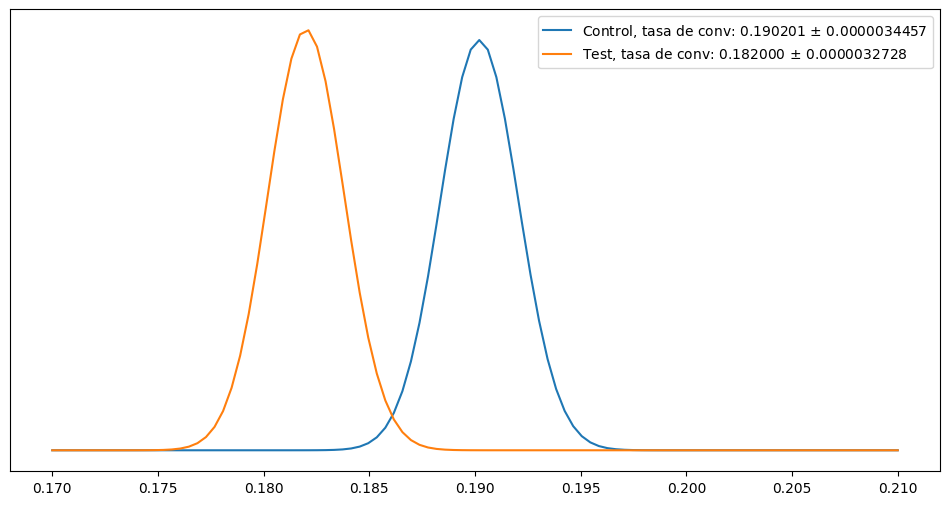

In [117]:
print(CR_ctrl, CR_test)
plt.figure(figsize = (12,6))
plot([beta_C, beta_T], ['Control', 'Test'], lsup = 0.17, linf = 0.21)

In [ ]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.